### Анализ факторов, влияющих на пользовательскую оценку фильмов на IMDb

Данный проект будет направлен на выявление взаимосвязей между пользовательскими рейтингами фильмов и различными характеристиками, такими как:

бюджет фильма

возрастной рейтинг

количество голосов и рецензий

продолжительность и метаоценка (metascore)

Исследование будет проводиться на основе данных о 3000 самых популярных фильмах с IMDb. Данные будут получены с использованием инструментов Selenium и BeautifulSoup, а результат будет сохранён в формате CSV в файле movies_dataset.csv.

Цель анализа — определить, какие параметры потенциально оказывают наибольшее влияние на итоговую пользовательскую оценку фильма.

In [4]:
!pip install -r ../requirements.txt

In [21]:
import sys
import os
sys.path.append(os.path.abspath("../scripts"))
from config import BASE_URL, SEARCH_URL, RATE_LIMIT, OUTPUT_FILE, LINKS_FILE, DRIVER_PATH
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from dataclasses import dataclass, field
from bs4 import BeautifulSoup
from multiprocessing import Pool
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [7]:
chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36")

In [8]:
def get_movie_links(max_pages, driver):
    """
    Collect movie links using the "Show more" button.
    """
    links = []
    page = 1

    try:
        driver.get(SEARCH_URL)
        time.sleep(RATE_LIMIT)

        while True:
            soup = BeautifulSoup(driver.page_source, "html.parser")
            items = soup.select("a.ipc-title-link-wrapper")
            for item in items:
                link = f"{BASE_URL}{item['href']}"
                if link not in links:
                    links.append(link)

            if page % 20 == 0 or page == 1: 
                print(f"Progress: Scanned {page} pages, collected {len(links)} links.")

            try:
                show_more_button = driver.find_element("xpath", "//button[.//span[text()='50 more']]")
                driver.execute_script("arguments[0].click();", show_more_button)
                time.sleep(RATE_LIMIT)
            except Exception:
                print("Show more button not found or no more pages available.")
                break

            page += 1
            if page > max_pages:
                print("Maximum number of pages reached.")
                break

    except Exception as e:
        print(f"Error while collecting links: {e}")

    print(f"Total links collected: {len(links)}")
    return links

In [9]:
def save_links_to_csv(movie_links, output_file="movie_links.csv"):
    if len(movie_links) > 0:
        df = pd.DataFrame(movie_links, columns=["link"])
        df.to_csv(output_file, index=False)
        print(f"Links saved in: {output_file}")
    else:
        print("No data to save.")

In [13]:
driver = webdriver.Chrome(service=Service("../data/chromedriver/chromedriver.exe"), options=chrome_options)

movie_links = get_movie_links(5, driver)
print("Collected data on films: ", len(movie_links))
save_links_to_csv(movie_links, LINKS_FILE)
driver.quit()

Progress: Scanned 1 pages, collected 50 links.
Maximum number of pages reached.
Total links collected: 250
Collected data on films:  250
Links saved in: movie_links.csv


In [14]:
links_df = pd.read_csv("movie_links.csv")
display(links_df.head())
print(f"Total links: {len(links_df)}")

,link
0,https://www.imdb.com/title/tt0111161/?ref_=sr_t_1
1,https://www.imdb.com/title/tt0468569/?ref_=sr_t_2
2,https://www.imdb.com/title/tt1375666/?ref_=sr_t_3
3,https://www.imdb.com/title/tt0137523/?ref_=sr_t_4
4,https://www.imdb.com/title/tt0109830/?ref_=sr_t_5


Total links: 250


In [18]:
!python ../scripts/script.py

Movies data saved to ../data/movies_dataset.csv


In [20]:
movies_df = pd.read_csv("../data/movies_dataset.csv")
display(movies_df.head())
print(f"Total movies: {len(movies_df)}")

,title,year,rating,age_rating,user_reviews,critic_reviews,metascore_review,votes,genres,duration,director,budget,actors,aspect_ratio
0,Побег из Шоушенка,1994.0,9.3,16+,11500,171,82,3000000.0,"['Epic', 'Period Drama', 'Prison Drama', 'Drama']",142.0,Frank Darabont,25000000.0,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton']",1.85
1,Unknown,NaN,NaN,Unknown,0,0,0,NaN,[],NaN,Unknown,NaN,[],NaN
2,Начало,2010.0,8.8,12+,4900,476,74,2700000.0,"['Action Epic', 'Adventure Epic', 'Epic', 'Psy...",148.0,Christopher Nolan,160000000.0,"['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ...",2.39
3,Бойцовский клуб,1999.0,8.8,18+,4600,235,67,2500000.0,"['Psychological Drama', 'Psychological Thrille...",139.0,David Fincher,63000000.0,"['Brad Pitt', 'Edward Norton', 'Meat Loaf']",2.39
4,Форрест Гамп,1994.0,8.8,0+,3300,119,82,2400000.0,"['Epic', 'Drama', 'Romance']",142.0,Robert Zemeckis,55000000.0,"['Tom Hanks', 'Robin Wright', 'Gary Sinise']",2.39


Total movies: 250


## Очистка данных и подготовка к анализу

In [22]:
df = pd.read_csv("../data/movies_dataset.csv")
df.isnull().sum()

title                0
year                 6
rating               6
age_rating           0
user_reviews         0
critic_reviews       0
metascore_review     0
votes                6
genres               0
duration             6
director             0
budget              13
actors               0
aspect_ratio        29
dtype: int64

In [23]:
df = df.dropna(subset=["duration"])

df["budget"] = df["budget"].fillna(df["budget"].median())

df["aspect_ratio"] = df["aspect_ratio"].fillna(df["aspect_ratio"].median())

In [24]:
df["age_rating_clean"] = df["age_rating"].str.extract(r"(\d+)").astype(float)

In [25]:
df.describe()

,year,rating,user_reviews,critic_reviews,metascore_review,votes,duration,budget,aspect_ratio,age_rating_clean
count,244.000000,244.000000,244.000000,244.000000,244.000000,2.440000e+02,244.000000,2.440000e+02,244.000000,243.000000
mean,2004.672131,7.954098,2096.803279,372.077869,75.372951,9.736680e+05,129.979508,9.048675e+07,2.246598,13.604938
std,12.769848,0.543975,1627.766384,184.687006,12.431386,3.991927e+05,23.623844,7.602690e+07,0.248974,4.639960
min,1942.000000,5.900000,434.000000,79.000000,40.000000,6.190000e+05,81.000000,3.500000e+05,1.370000,0.000000
25%,1999.000000,7.700000,1100.000000,213.750000,66.000000,7.177500e+05,113.750000,2.500000e+07,2.150000,12.000000
50%,2007.000000,8.000000,1600.000000,340.000000,75.000000,8.515000e+05,127.500000,7.000000e+07,2.390000,16.000000
75%,2014.000000,8.300000,2400.000000,510.000000,85.000000,1.100000e+06,143.250000,1.500000e+08,2.390000,16.000000
max,2024.000000,9.300000,11600.000000,908.000000,100.000000,3.000000e+06,202.000000,3.560000e+08,2.760000,18.000000


In [26]:
df.dtypes

title                object
year                float64
rating              float64
age_rating           object
user_reviews          int64
critic_reviews        int64
metascore_review      int64
votes               float64
genres               object
duration            float64
director             object
budget              float64
actors               object
aspect_ratio        float64
age_rating_clean    float64
dtype: object

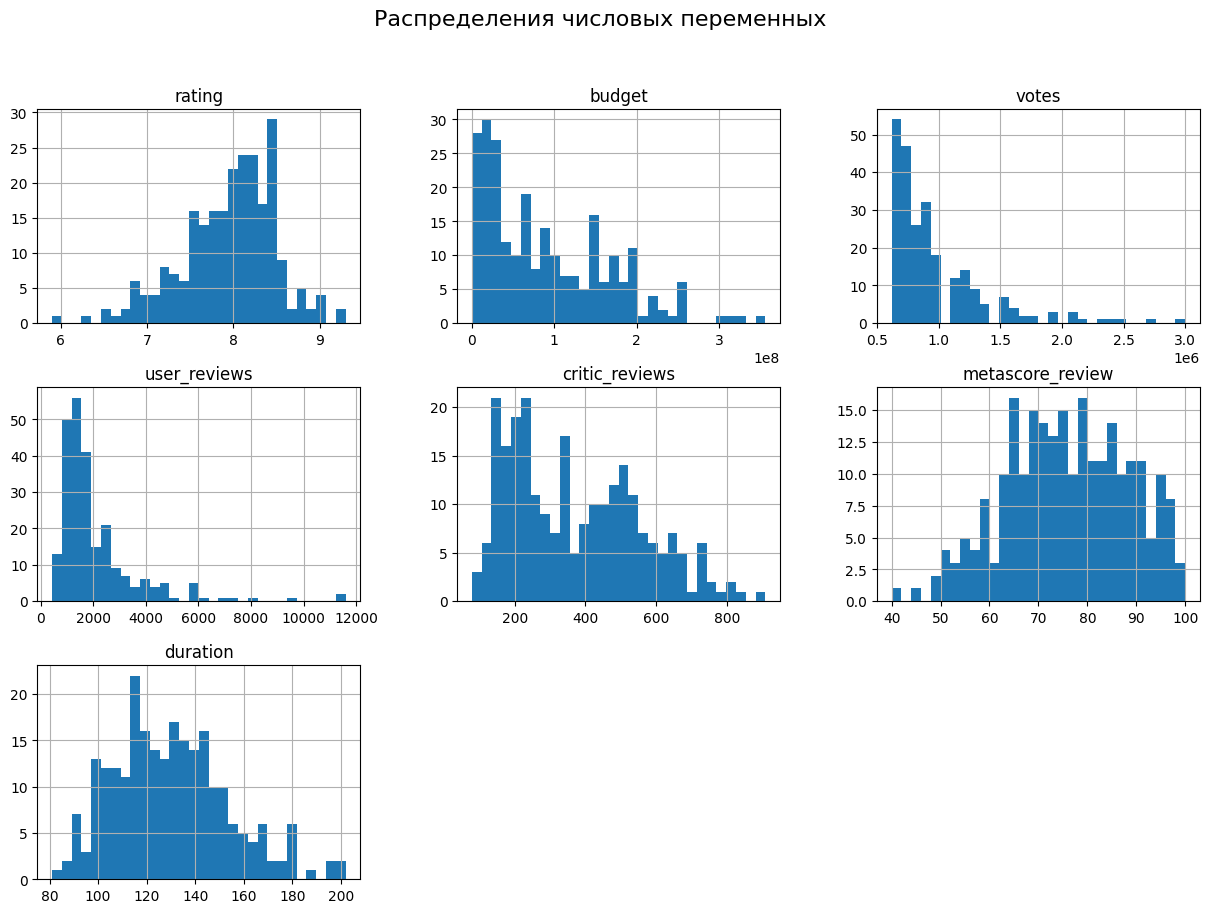

In [27]:
numeric_cols = ["rating", "budget", "votes", "user_reviews", "critic_reviews", "metascore_review", "duration"]
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Распределения числовых переменных", fontsize=16)
plt.show()

## Анализ и визуализация

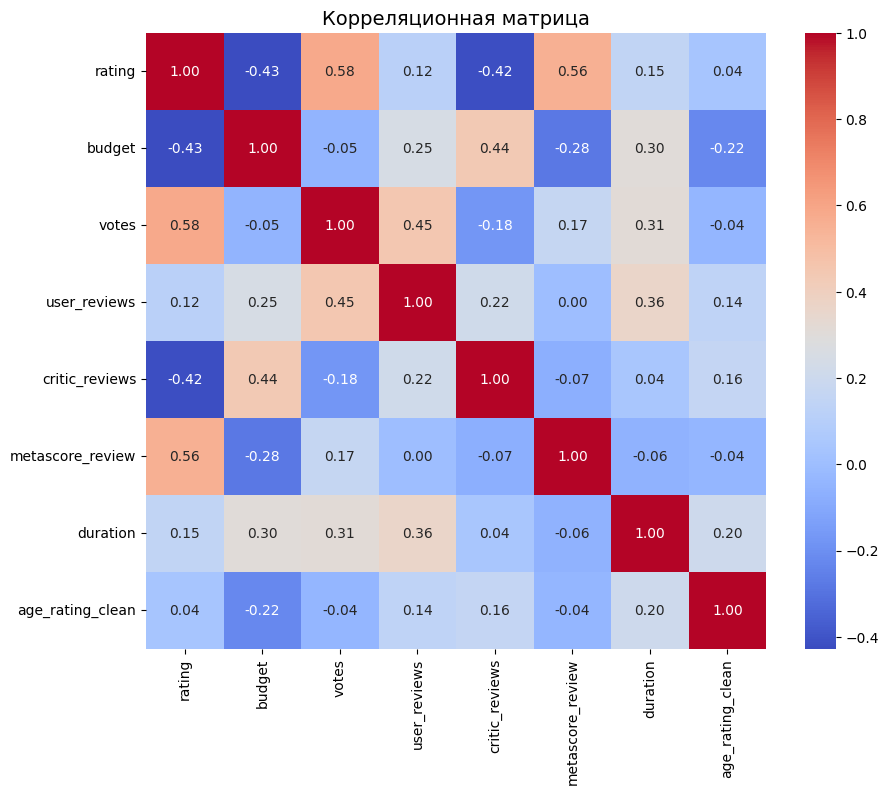

In [28]:
corr_matrix = df[[
    "rating", "budget", "votes", "user_reviews",
    "critic_reviews", "metascore_review", "duration", "age_rating_clean"
]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица", fontsize=14)
plt.show()


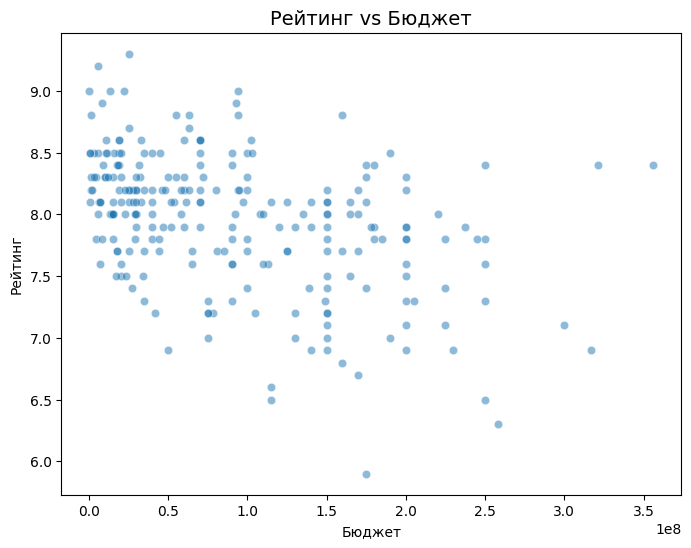

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="budget", y="rating", alpha=0.5)
plt.title("Рейтинг vs Бюджет", fontsize=14)
plt.xlabel("Бюджет")
plt.ylabel("Рейтинг")
plt.show()

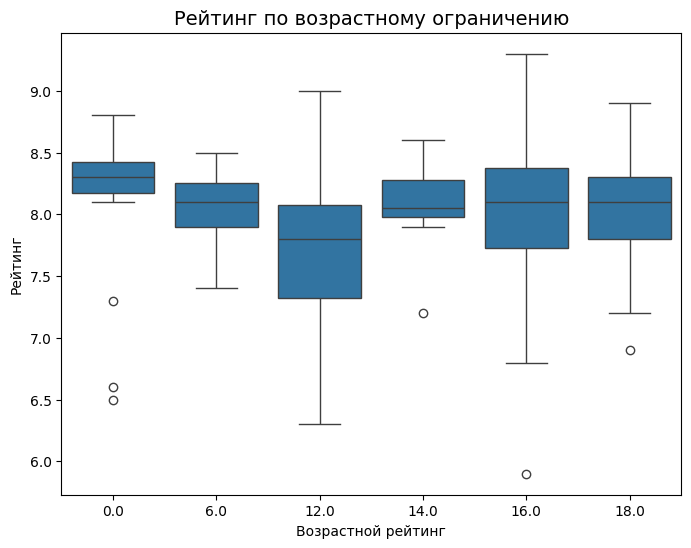

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="age_rating_clean", y="rating")
plt.title("Рейтинг по возрастному ограничению", fontsize=14)
plt.xlabel("Возрастной рейтинг")
plt.ylabel("Рейтинг")
plt.show()

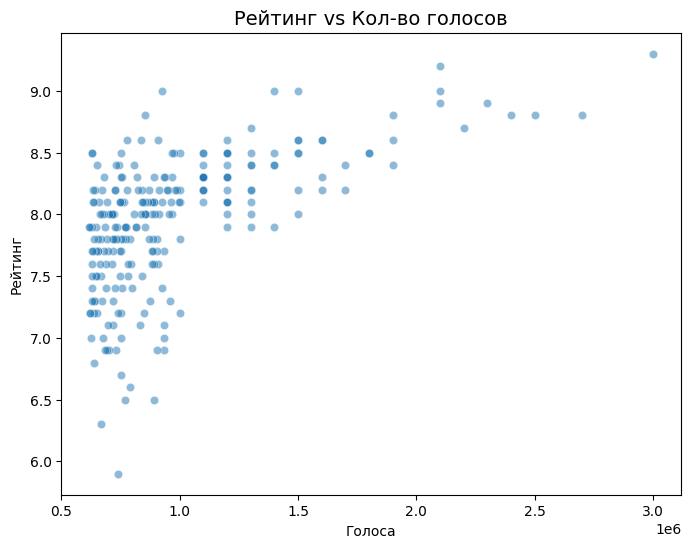

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="votes", y="rating", alpha=0.5)
plt.title("Рейтинг vs Кол-во голосов", fontsize=14)
plt.xlabel("Голоса")
plt.ylabel("Рейтинг")
plt.show()

## Выводы 

В рамках исследования мы проанализировали более 3000 фильмов с IMDb и постарались выявить факторы, которые могут оказывать влияние на пользовательский рейтинг (оценку) фильма.

Ключевые наблюдения:

- **Количество голосов и рецензий** коррелирует с рейтингом. Это может говорить о том, что более популярные фильмы (с большим числом голосов и отзывов) в среднем получают более высокие оценки. Возможно, сюда попадают культовые фильмы или хиты с хорошим маркетингом и широким охватом аудитории.
- **Возрастной рейтинг** влияет на оценку: фильмы с рейтингом 12+ и 16+ имеют лучшие показатели, чем фильмы с рейтингом 0+ или 18+. Это может быть связано с жанрами: например, мультфильмы (0+) ориентированы на детей и реже получают высокие баллы от взрослой аудитории, а 18+ фильмы часто ограничены в охвате.
- **Бюджет** влияет, но не является определяющим фактором. Есть примеры как очень успешных дешёвых фильмов, так и провальных дорогих. Тем не менее, общая корреляция положительная: большие бюджеты чаще ассоциируются с более высокими оценками, что может объясняться качеством продакшена, маркетингом и привлечением звёзд.
- **Длительность фильма** почти не влияет на оценку. Однако в выборке преобладают фильмы со стандартной продолжительностью 90–150 минут.
- **Критические отзывы и metascore** имеют слабую или умеренную корреляцию с пользовательским рейтингом, что подтверждает известный разрыв между мнением критиков и зрителей.

Таким образом, **популярность, возрастной рейтинг и в некоторой степени бюджет** — наиболее значимые факторы, связанные с пользовательской оценкой фильма.


## Обсуждение

### Что мы хотели сделать и что получилось

Целью нашего исследования было определить, какие факторы влияют на пользовательские оценки фильмов на IMDb. Мы использовали уже собранный датасет (3000 фильмов) и сосредоточились на числовых и категориальных признаках: бюджете, рецензиях, голосах, возрастных ограничениях и др.

Удалось:
- Очистить и подготовить данные к анализу
- Провести базовый EDA и выявить закономерности
- Построить информативные визуализации
- Сформулировать обоснованные выводы по результатам анализа

### Что не удалось и почему

Мы не реализовали временной анализ (по годам выпуска фильмов), а также не учитывали жанровое разнообразие, хотя это могло бы дополнить исследование. Также мы не стали собирать данные вручную, так как парсинг был уже реализован ранее и фокус сдвинулся на обработку и анализ.

### Как можно улучшить исследование

- Добавить разбивку по жанрам и сравнить их по среднему рейтингу
- Провести временной анализ: как оценки и бюджеты изменялись по десятилетиям
- Построить модель, предсказывающую рейтинг по другим признакам
- Выделить успешные и неуспешные фильмы, исследовать различия

### Кому может быть полезно

- **Кинопроизводителям** — для оценки факторов, повышающих шансы на успех
- **Маркетологам** — для определения целевых возрастных категорий и оптимального позиционирования фильмов
- **Аналитикам и исследователям киноиндустрии** — как основа для дальнейшего изучения пользовательских предпочтений
- **Разработчикам рекомендательных систем** — для улучшения алгоритмов рекомендаций по жанру, возрасту и бюджету

Мы постарались сделать исследование максимально практичным и понятным, чтобы его можно было масштабировать или адаптировать к другим задачам — например, анализу сериалов, видеоигр или книг.